In [33]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score, mutual_info_score
from sklearn.preprocessing import StandardScaler


In [34]:
customers = pd.read_csv("data/customers.csv")
products = pd.read_csv("data/products.csv")
transactions = pd.read_csv("data/transactions.csv")

## Merge datasets

In [35]:
customer_transactions = pd.merge(customers, transactions, on="CustomerID")

## Feature engineering
### Aggregate transaction data by CustomerID

In [36]:
transaction_features = customer_transactions.groupby("CustomerID").agg(
TotalTransactions=("TransactionID", "count"),
TotalQuantity=("Quantity", "sum"),
TotalValue=("TotalValue", "sum"),
).reset_index()


### Merge with customer profile information

In [37]:
profile_data = customers[["CustomerID", "Region", "SignupDate"]]
profile_data["SignupYear"] = pd.to_datetime(profile_data["SignupDate"]).dt.year
profile_data["Region"] = profile_data["Region"].astype("category").cat.codes

### Combine features for clustering

In [38]:
clustering_data = pd.merge(profile_data, transaction_features, on="CustomerID")
clustering_data = clustering_data.drop(columns=["CustomerID", "SignupDate"])

### Standardize the data

In [39]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

### Apply clustering and evaluate

In [40]:
def cluster_and_evaluate(data, max_clusters=10):
    results = {
    "clusters": [],
    "db_index": [],
    "silhouette_score": [],
    "calinski_harabasz_score": [],
    "mutual_info_score": []
    }

    # Loop through different cluster counts
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(data)

        # Evaluate clustering metrics
        db_index = davies_bouldin_score(data, labels)
        silhouette = silhouette_score(data, labels)
        calinski_score = calinski_harabasz_score(data, labels)

        # For ARI and MI, we need consistent labels
        true_labels = np.array(clustering_data.index) # Use index as true labels
        ari = adjusted_rand_score(true_labels, labels)
        mi = mutual_info_score(true_labels, labels)

        # Store results for each cluster count
        results["clusters"].append(n_clusters)
        results["db_index"].append(db_index)
        results["silhouette_score"].append(silhouette)
        results["calinski_harabasz_score"].append(calinski_score)
        results["mutual_info_score"].append(mi)

    return results

### Fit the data to the clustering model

In [41]:

results = cluster_and_evaluate(scaled_data, max_clusters=10)

optimal_clusters = results["clusters"][np.argmin(results["db_index"])]

final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
final_labels = final_kmeans.fit_predict(scaled_data)

clustering_data["Cluster"] = final_labels

print("Clustering Results:")
print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"DB Index for Optimal Clustering: {results['db_index'][np.argmin(results['db_index'])]}")
print(f"Silhouette Score for Optimal Clustering: {results['silhouette_score'][np.argmin(results['db_index'])]}")
print(f"Calinski-Harabasz Score for Optimal Clustering: {results['calinski_harabasz_score'][np.argmin(results['db_index'])]}")
print(f"Mutual Information Score for Optimal Clustering: {results['mutual_info_score'][np.argmin(results['db_index'])]}")

Clustering Results:
Optimal Number of Clusters: 9
DB Index for Optimal Clustering: 1.1862802936602128
Silhouette Score for Optimal Clustering: 0.22584562168709876
Calinski-Harabasz Score for Optimal Clustering: 65.06608643348802
Mutual Information Score for Optimal Clustering: 2.1683861435353995


### Visualize the results

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


### 1. Visualize clusters using PCA

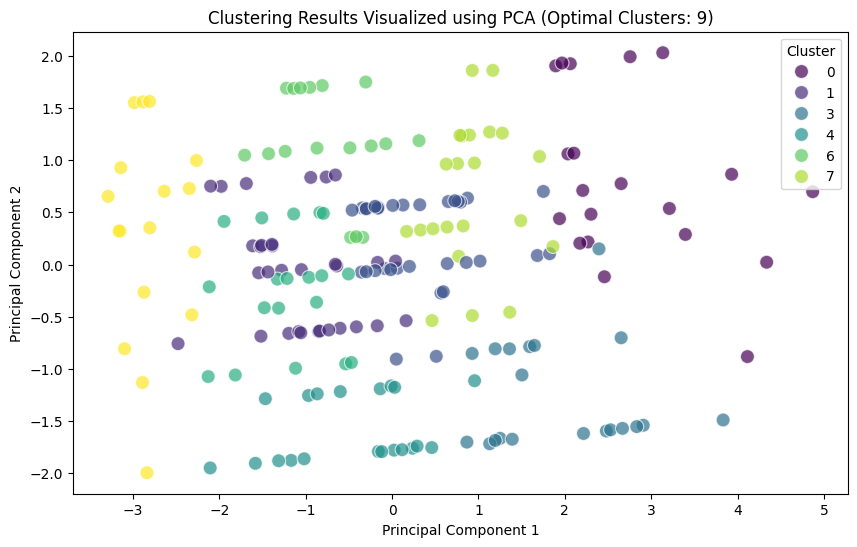

In [43]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(pca_components, columns=["PCA1", "PCA2"])
pca_df["Cluster"] = clustering_data["Cluster"]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x="PCA1", y="PCA2", hue="Cluster", palette="viridis", s=100, alpha=0.7)
plt.title(f"Clustering Results Visualized using PCA (Optimal Clusters: {optimal_clusters})")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", loc="best")
plt.show()

###  2. Visualize the distribution of customers across clusters

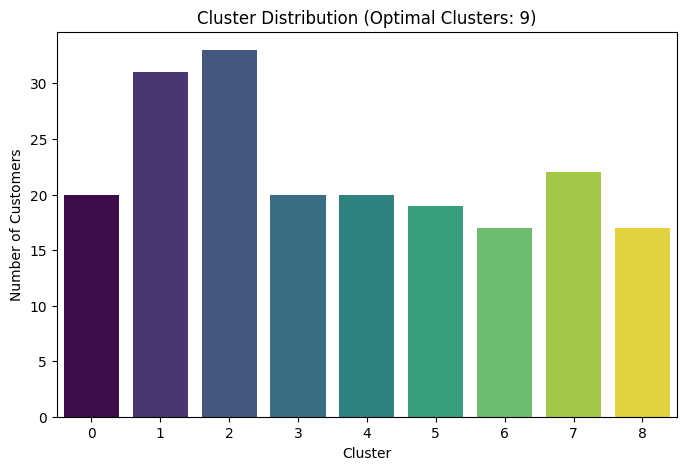

In [44]:
plt.figure(figsize=(8, 5))
sns.countplot(x="Cluster", data=clustering_data, hue="Cluster", palette="viridis", legend=False)
plt.title(f"Cluster Distribution (Optimal Clusters: {optimal_clusters})")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.show()


### 3. Silhouette Plot

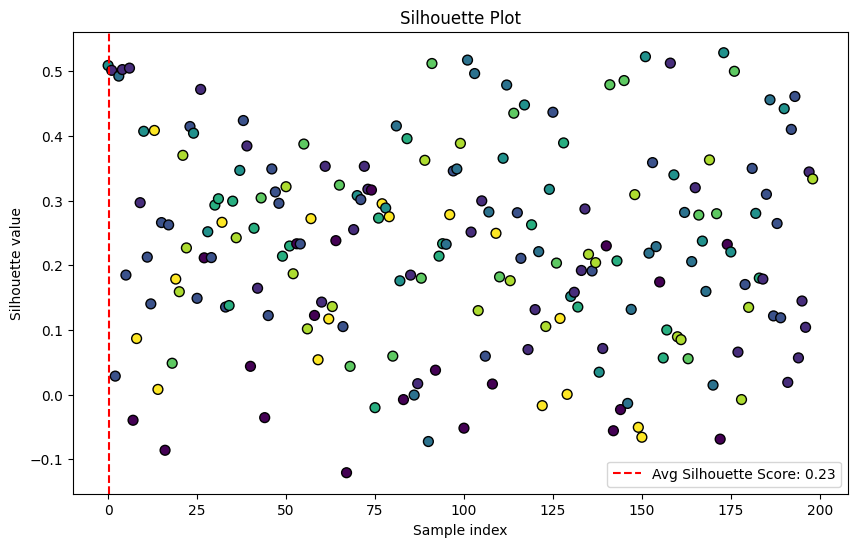

In [45]:
from sklearn.metrics import silhouette_samples, silhouette_score

sil_score = silhouette_score(scaled_data, final_labels)

silhouette_values = silhouette_samples(scaled_data, final_labels)

plt.figure(figsize=(10, 6))
plt.scatter(range(len(silhouette_values)), silhouette_values, c=final_labels, cmap='viridis', edgecolor='k', s=50)
plt.axvline(x=sil_score, color='red', linestyle='--', label=f"Avg Silhouette Score: {sil_score:.2f}")
plt.title("Silhouette Plot")
plt.xlabel("Sample index")
plt.ylabel("Silhouette value")
plt.legend()
plt.show()

In [46]:
clustering_data.to_csv("Customer_Segmentation.csv", index=False)